# Manifold GP Semi-Supervised Learning via Precision Matrix on 1D Manifold

## Preamble

This notebook provides an example of how to perform Gaussian Process Regression on a 1D manifold. In this example we consider a supervised learning scenario, namely the number of labeled data points is equivalent to the number of the sampled points from the underlying manifold.

In [1]:
import torch
import gpytorch
import numpy as np

%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from importlib.resources import files

from manifold_gp.kernels.riemann_matern_kernel import RiemannMaternKernel
from manifold_gp.models.riemann_gp import RiemannGP
from manifold_gp.models.vanilla_gp import VanillaGP
from manifold_gp.utils.mesh_helper import groundtruth_from_samples
from manifold_gp.utils.file_read import get_data

from manifold_gp.priors.inverse_gamma_prior import InverseGammaPrior
from gpytorch.priors import NormalPrior, GammaPrior

## Dataset Preprocessing

### Load

In [2]:
data_path = files('manifold_gp.data').joinpath('dumbbell.msh')
data = get_data(data_path, "Nodes", "Elements")

vertices = data['Nodes'][:, 1:-1]
edges = data['Elements'][:, -2:].astype(int) - 1
truth, geodesics = groundtruth_from_samples(vertices,edges)

sampled_x = torch.from_numpy(vertices).float()
sampled_y = torch.from_numpy(truth).float()
(m, n) = sampled_x.shape

num_train = 10
num_test = 1000
normalize_features = False
normalize_labels = True

### Noise Features

In [3]:
noise_sampled_x = 0.0
noisy_x = sampled_x + noise_sampled_x * torch.randn(m, n)

### Trainset & Testset

In [4]:
torch.manual_seed(1337)
rand_idx = torch.randperm(m)
train_idx = rand_idx[:num_train]
train_x, train_y = noisy_x[train_idx, :], sampled_y[train_idx]

noise_train_y = 0.01
train_y += noise_train_y * torch.randn(num_train)

test_idx = rand_idx[num_train:num_train+num_test]
test_x, test_y = sampled_x[test_idx, :], sampled_y[test_idx]

noise_test_y = 0.0
test_y += noise_test_y * torch.randn(num_test)

if normalize_features:
    mu_x, std_x = noisy_x.mean(dim=-2, keepdim=True), train_x.std(dim=-2, keepdim=True) + 1e-6
    noisy_x.sub_(mu_x).div_(std_x)
    train_x.sub_(mu_x).div_(std_x)
    test_x.sub_(mu_x).div_(std_x)
    
if normalize_labels:
    mu_y, std_y = train_y.mean(), train_y.std()
    train_y.sub_(mu_y).div_(std_y)
    test_y.sub_(mu_y).div_(std_y)
    sampled_y.sub_(mu_y).div_(std_y)

### Move Data to Device

In [5]:
noisy_x, sampled_y = noisy_x.contiguous(), sampled_y.contiguous()
train_x, train_y = train_x.contiguous(), train_y.contiguous()
test_x, test_y = test_x.contiguous(), test_y.contiguous()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
noisy_x = noisy_x.to(device)
train_x, train_y = train_x.to(device), train_y.to(device)
test_x, test_y = test_x.to(device), test_y.to(device)

if normalize_features:
    mu_x, std_x = mu_x.to(device), std_x.to(device)

## Vanilla Pre-Trained

In [6]:
%%capture
model_vanilla = VanillaGP(
    train_x, 
    train_y, 
    gpytorch.likelihoods.GaussianLikelihood(), 
    gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) # gpytorch.kernels.RBFKernel(), gpytorch.kernels.RFFKernel(100)
).to(device)
model_vanilla.vanilla_train(lr=1e-1, iter=200, verbose=False)
model_vanilla.likelihood.eval()
model_vanilla.eval()

## Model

In [7]:
%%capture
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(1e-8),
    noise_prior=None  # NormalPrior(torch.tensor([0.0]).to(device),  torch.tensor([1/9]).sqrt().to(device))
)

kernel = gpytorch.kernels.ScaleKernel(
    RiemannMaternKernel(
        nu=1,
        nodes=noisy_x,
        neighbors=10,
        operator="randomwalk",
        modes=50,
        ball_scale=3.0,
        epsilon_prior=False,
        lengthscale_prior=None
    ),
    outputscale_prior=None  # NormalPrior(torch.tensor([1.0]).to(device),  torch.tensor([1/9]).sqrt().to(device))
)

model = RiemannGP(train_x, train_y, likelihood, kernel, train_idx).to(device)

## Train

In [8]:
%%capture
hypers = {
    'likelihood.noise_covar.noise': 1e-2,
    'covar_module.base_kernel.epsilon': 0.5,
    'covar_module.base_kernel.lengthscale': 1.0,
    'covar_module.outputscale': 1.0,
}
model.initialize(**hypers)

In [9]:
model.manifold_informed_train(lr=1e-1, iter=100, norm_step_size=100, verbose=True)

Iter: 0, LR: 0.100, Loss: 5.358, NoiseVar: 0.010, SignalVar: 0.550, Lengthscale: 1.000, Epsilon: 0.500
Iter: 1, LR: 0.100, Loss: 5.340, NoiseVar: 0.009, SignalVar: 0.509, Lengthscale: 0.938, Epsilon: 0.462
Iter: 2, LR: 0.100, Loss: 5.342, NoiseVar: 0.009, SignalVar: 0.507, Lengthscale: 0.950, Epsilon: 0.454
Iter: 3, LR: 0.100, Loss: 5.314, NoiseVar: 0.009, SignalVar: 0.521, Lengthscale: 0.984, Epsilon: 0.460
Iter: 4, LR: 0.100, Loss: 5.313, NoiseVar: 0.009, SignalVar: 0.537, Lengthscale: 1.021, Epsilon: 0.467
Iter: 5, LR: 0.100, Loss: 5.319, NoiseVar: 0.009, SignalVar: 0.545, Lengthscale: 1.052, Epsilon: 0.465
Iter: 6, LR: 0.100, Loss: 5.308, NoiseVar: 0.009, SignalVar: 0.544, Lengthscale: 1.072, Epsilon: 0.455
Iter: 7, LR: 0.100, Loss: 5.291, NoiseVar: 0.009, SignalVar: 0.537, Lengthscale: 1.087, Epsilon: 0.440
Iter: 8, LR: 0.100, Loss: 5.284, NoiseVar: 0.009, SignalVar: 0.530, Lengthscale: 1.102, Epsilon: 0.423
Iter: 9, LR: 0.100, Loss: 5.283, NoiseVar: 0.008, SignalVar: 0.525, Lengt

Iter: 81, LR: 0.100, Loss: 3.517, NoiseVar: 0.000, SignalVar: 3.078, Lengthscale: 5.153, Epsilon: 0.070
Iter: 82, LR: 0.100, Loss: 3.516, NoiseVar: 0.000, SignalVar: 3.097, Lengthscale: 5.167, Epsilon: 0.070
Iter: 83, LR: 0.100, Loss: 3.515, NoiseVar: 0.000, SignalVar: 3.116, Lengthscale: 5.180, Epsilon: 0.070
Iter: 84, LR: 0.100, Loss: 3.515, NoiseVar: 0.000, SignalVar: 3.136, Lengthscale: 5.193, Epsilon: 0.069
Iter: 85, LR: 0.100, Loss: 3.514, NoiseVar: 0.000, SignalVar: 3.155, Lengthscale: 5.206, Epsilon: 0.069
Iter: 86, LR: 0.100, Loss: 3.514, NoiseVar: 0.000, SignalVar: 3.173, Lengthscale: 5.218, Epsilon: 0.069
Iter: 87, LR: 0.100, Loss: 3.513, NoiseVar: 0.000, SignalVar: 3.191, Lengthscale: 5.230, Epsilon: 0.069
Iter: 88, LR: 0.100, Loss: 3.513, NoiseVar: 0.000, SignalVar: 3.209, Lengthscale: 5.242, Epsilon: 0.068
Iter: 89, LR: 0.100, Loss: 3.512, NoiseVar: 0.000, SignalVar: 3.227, Lengthscale: 5.254, Epsilon: 0.068
Iter: 90, LR: 0.100, Loss: 3.511, NoiseVar: 0.000, SignalVar: 3.

## Evaluation

In [10]:
%%capture
likelihood.eval()
model.eval()


## Metrics

In [11]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds_test = likelihood(model(test_x))
        
    error = test_y - preds_test.mean
    covar = preds_test.lazy_covariance_matrix.evaluate_kernel()
    inv_quad, logdet = covar.inv_quad_logdet(inv_quad_rhs=error.unsqueeze(-1), logdet=True)
    
    rmse = (error.square().sum()/num_test).sqrt()
    nll = 0.5 * sum([inv_quad, logdet, error.size(-1)* np.log(2 * np.pi)])/num_test
    model._clear_cache()
    
print("RMSE: ", rmse)
print("NLL: ", nll)

RMSE:  tensor(0.4563, device='cuda:0')
NLL:  tensor(-3.1214, device='cuda:0')


## Plot

In [12]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds_manifold = model(noisy_x)
    
    resolution = 100
    x, y = torch.meshgrid(torch.linspace(-1.6, 1.6, resolution), torch.linspace(-1.0, 1.0, resolution), indexing='xy')
    grid_x = torch.stack((torch.ravel(x), torch.ravel(y)), dim=1).to(device).requires_grad_(True)
    
    if normalize_features:
        preds_ambient = model(grid_x.sub(mu_x).div(std_x))
        preds_vanilla = model_vanilla(grid_x.sub(mu_x).div(std_x))
        scale_ambient = kernel.base_kernel.scale_posterior(grid_x.sub(mu_x).div(std_x), beta=0.01)
        sampled_x.mul_(std_x).add_(mu_x)
        train_x.mul_(std_x).add_(mu_x)
        test_x.mul_(std_x).add_(mu_x)
    else:
        preds_ambient = model(grid_x)
        preds_vanilla = model_vanilla(grid_x)
        scale_ambient = kernel.base_kernel.scale_posterior(grid_x, beta=0.01)

### Ground Truth

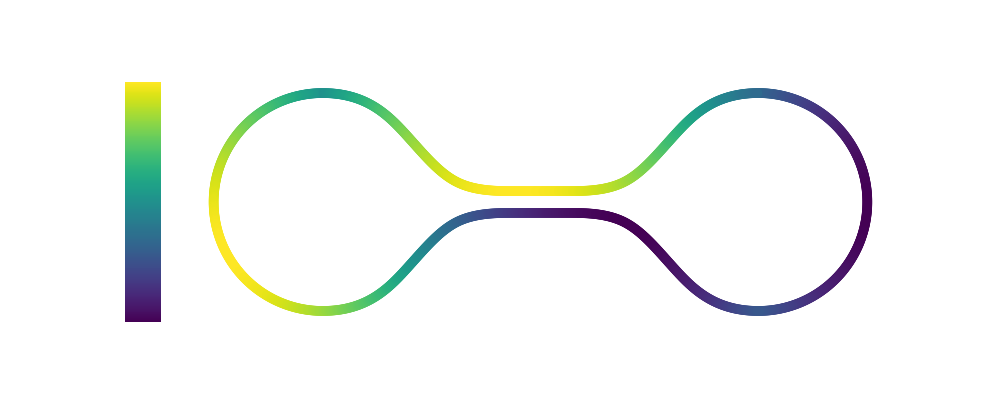

In [13]:
with torch.no_grad():
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    im = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=sampled_y.numpy(), vmin=sampled_y.min(), vmax=sampled_y.max())
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("left", size="5%", pad=0.2)
    cbar = fig.colorbar(im, cax=cax)
    cax.yaxis.set_ticks_position("left")
    cbar.outline.set_visible(False)
    cbar.set_ticks([])
    cbar.ax.tick_params(size=0)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    fig.patch.set_visible(False)
    ax.axis('off')
    
    ax.axis('equal')

### Posterior Mean

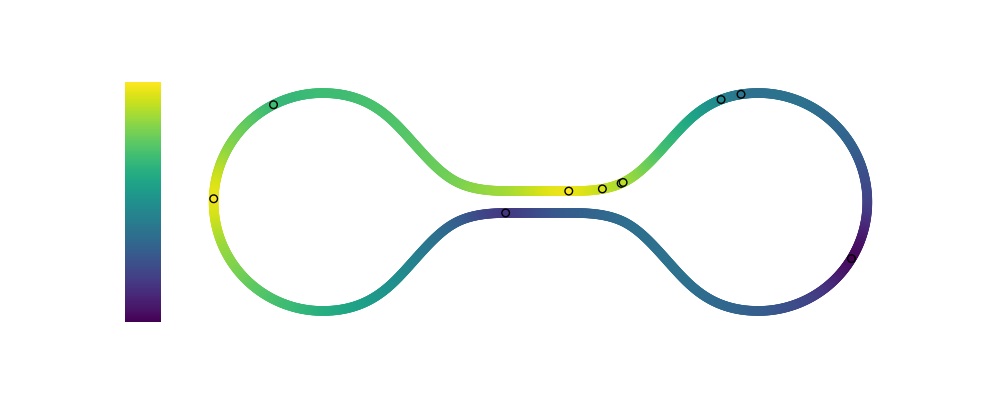

In [15]:
posterior_mean_manifold = preds_manifold.mean.cpu().numpy()
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
im = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=posterior_mean_manifold, vmin=sampled_y.min(), vmax=sampled_y.max())
ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c=posterior_mean_manifold[train_idx],s=30.0, zorder=2, edgecolors='black')
divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="5%", pad=0.2)
cbar = fig.colorbar(im, cax=cax)
cax.yaxis.set_ticks_position("left")
cbar.outline.set_visible(False)
cbar.set_ticks([])
cbar.ax.tick_params(size=0)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
fig.patch.set_visible(False)
ax.axis('off')

ax.axis('equal')

fig.savefig("1d_high_noise.png", format="png", bbox_inches="tight")


### Kernel Evaluation

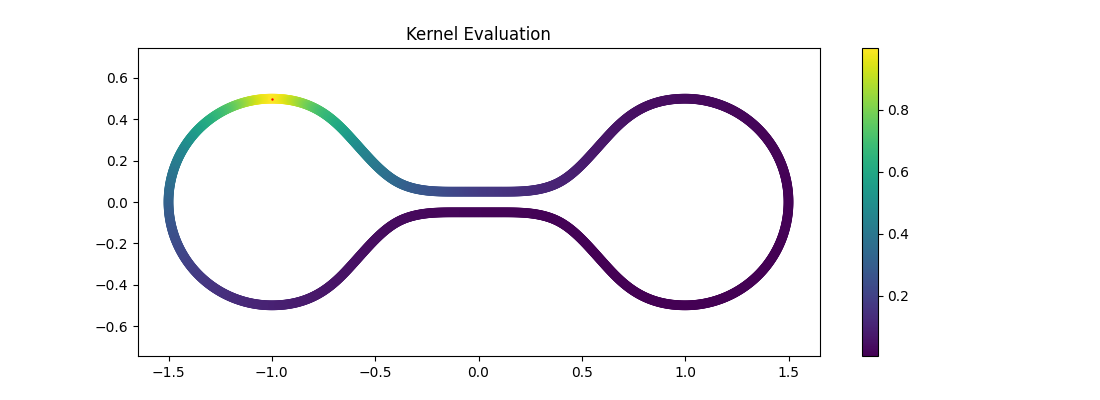

In [16]:
with torch.no_grad():
    k_base = kernel.base_kernel(noisy_x[0, :].unsqueeze(0), noisy_x[0, :].unsqueeze(0)).evaluate()
    kernel_eval_manifold = (kernel.base_kernel(noisy_x[0, :].unsqueeze(0), noisy_x).evaluate()/k_base).squeeze().cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=kernel_eval_manifold)
    ax.scatter(noisy_x.cpu().numpy()[0, 0], noisy_x.cpu().numpy()[0, 1], c='r', s=0.5)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Kernel Evaluation')

### Features

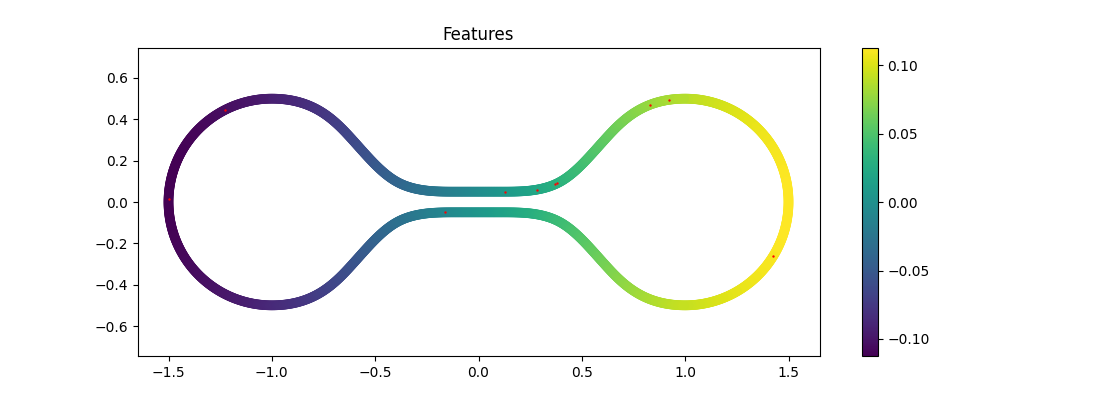

In [19]:
with torch.no_grad():
    c = 3.0
    l_features = kernel.base_kernel.features(noisy_x, c=c)[:,2].cpu().numpy()
    e_features = kernel.base_kernel.eigenvectors[:,2].cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=e_features)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    circle = plt.Circle((noisy_x.cpu().numpy()[0, 0], noisy_x.cpu().numpy()[0, 1]), 
                        c*kernel.base_kernel.epsilon.cpu().numpy(), color='k', fill=False)
#     ax.add_patch(circle)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Features')

### Prior Standard Deviation

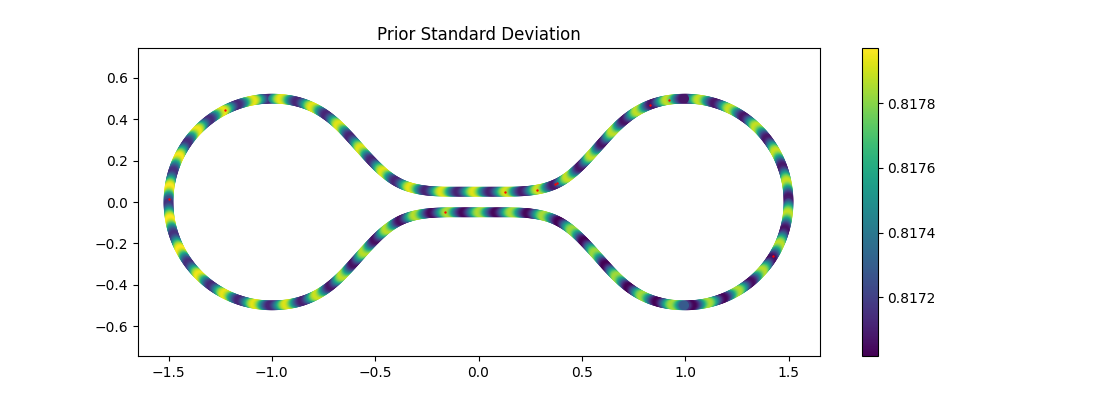

In [20]:
with torch.no_grad():
    prior_std_manifold = model.covar_module(noisy_x, noisy_x, diag=True).sqrt().cpu().numpy()
#     prior_std_manifold = kernel.base_kernel(noisy_x, noisy_x, diag=True).sqrt().cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=prior_std_manifold)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Prior Standard Deviation')

### Posterior Standard Deviation

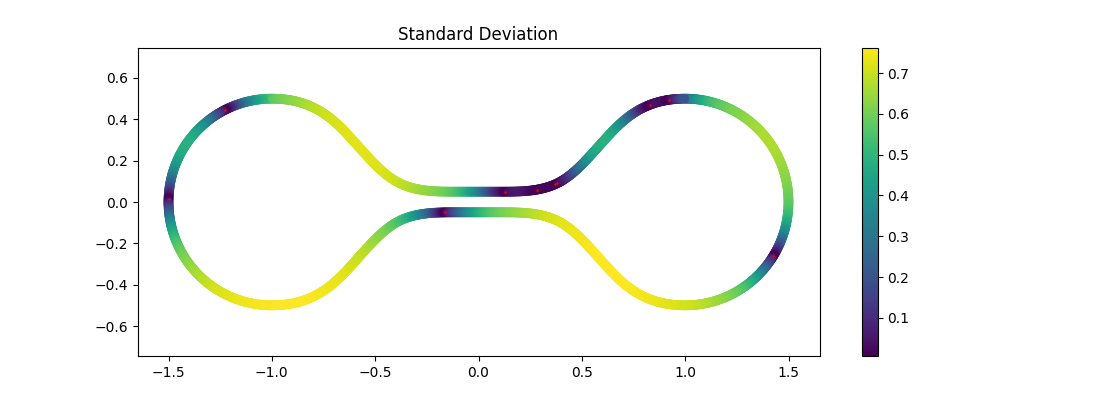

In [21]:
with torch.no_grad():
    posterior_std_manifold = preds_manifold.stddev.cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=posterior_std_manifold)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Standard Deviation')

### Ambient Posterior Mean

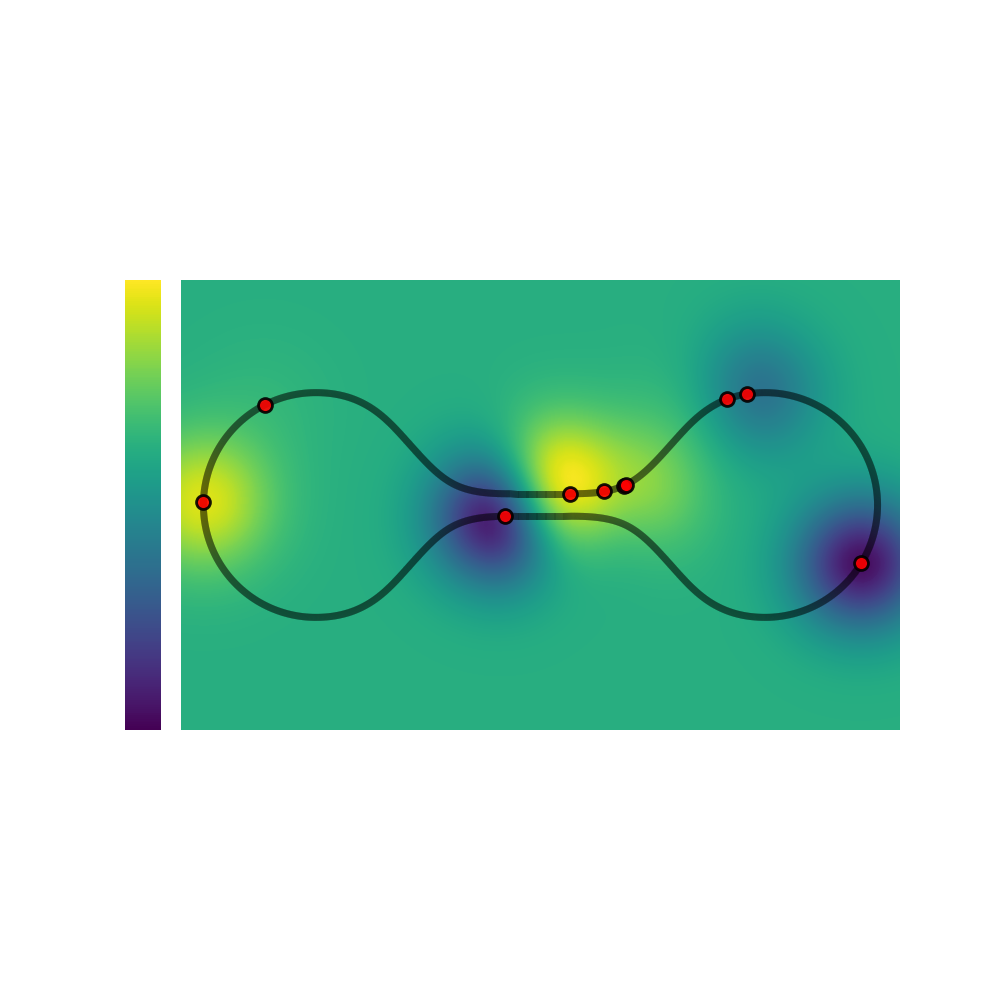

In [22]:
with torch.no_grad():
#     posterior_mean_ambient = preds_ambient.mean.cpu().numpy()
    posterior_mean_ambient = preds_vanilla.mean.cpu().numpy()
#     posterior_mean_ambient = (scale_ambient*preds_ambient.mean + (1-scale_ambient)*preds_vanilla.mean).cpu().numpy()
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    levels = np.linspace(-1.85, 1.1, 500)
    im = ax.contourf(x.cpu().numpy(), y.cpu().numpy(), posterior_mean_ambient.reshape(resolution, -1),levels=levels)
    # ax.contour(x.cpu(), y.cpu(), posterior_mean_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
#     ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c='k', s=0.5)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], facecolors='red',s=100.0, zorder=2, 
               edgecolors='black', linewidth=2, alpha=0.9)
    for edge in edges:
        start = vertices[edge[0]]
        end = vertices[edge[1]]
        ax.plot([start[0], end[0]], [start[1], end[1]], color='black', zorder=1, linewidth='5',alpha=0.1)
        
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("left", size="5%", pad=0.2)
    cbar = fig.colorbar(im, cax=cax, ticks=[-1.85, 0, 1.1])
    cax.yaxis.set_ticks_position("left")
    cbar.outline.set_visible(False)
    cbar.set_ticks([])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    fig.patch.set_visible(False)
    ax.axis('off')
    
    ax.axis('equal')
    
    for c in im.collections:
        c.set_edgecolor("face")
#     fig.tight_layout()
    fig.savefig("1d_vanilla_prediction.png", format="png", bbox_inches="tight")
#     ax.set_title('Posterior Mean')

### Ambient Kernel Evaluation

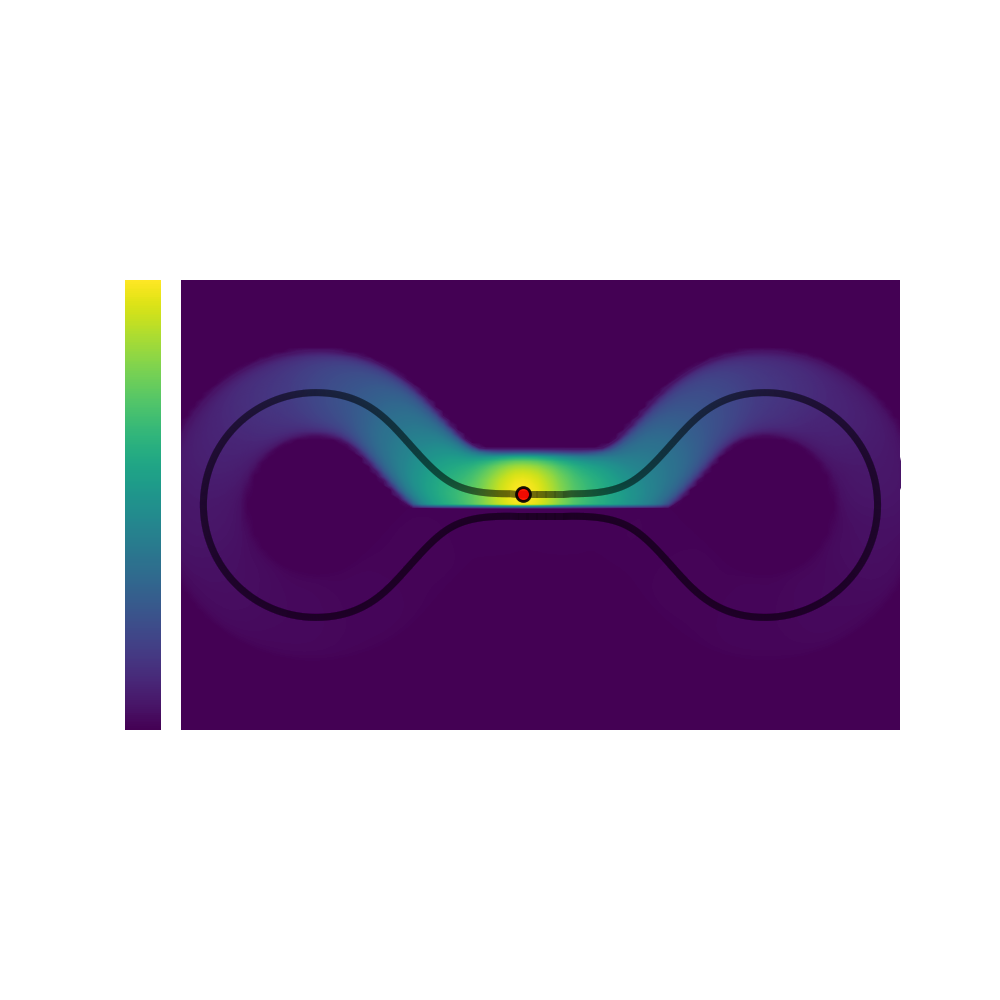

In [23]:
with torch.no_grad():
    kernel_eval_ambient = (scale_ambient*kernel.base_kernel(noisy_x[848, :].unsqueeze(0), grid_x).evaluate().squeeze()).cpu().numpy()
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    im = ax.contourf(x.cpu(), y.cpu(), kernel_eval_ambient.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), kernel_eval_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    
    ax.scatter(noisy_x.cpu().numpy()[848, 0], noisy_x.cpu().numpy()[848, 1], facecolors='red',s=100.0, zorder=2, 
               edgecolors='black', linewidth=2, alpha=0.9)
    
    for edge in edges:
        start = vertices[edge[0]]
        end = vertices[edge[1]]
        ax.plot([start[0], end[0]], [start[1], end[1]], color='black', zorder=1, linewidth='5',alpha=0.1)
        
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("left", size="5%", pad=0.2)
    cbar = fig.colorbar(im, cax=cax, ticks=[-1.85, 0, 1.1])
    cax.yaxis.set_ticks_position("left")
    cbar.outline.set_visible(False)
    cbar.set_ticks([])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    fig.patch.set_visible(False)
    ax.axis('off')
    
    for c in im.collections:
        c.set_edgecolor("face")
    
    ax.axis('equal')
    fig.savefig("1d_kernel_eval.png", format="png", bbox_inches="tight")

### Ambient Features

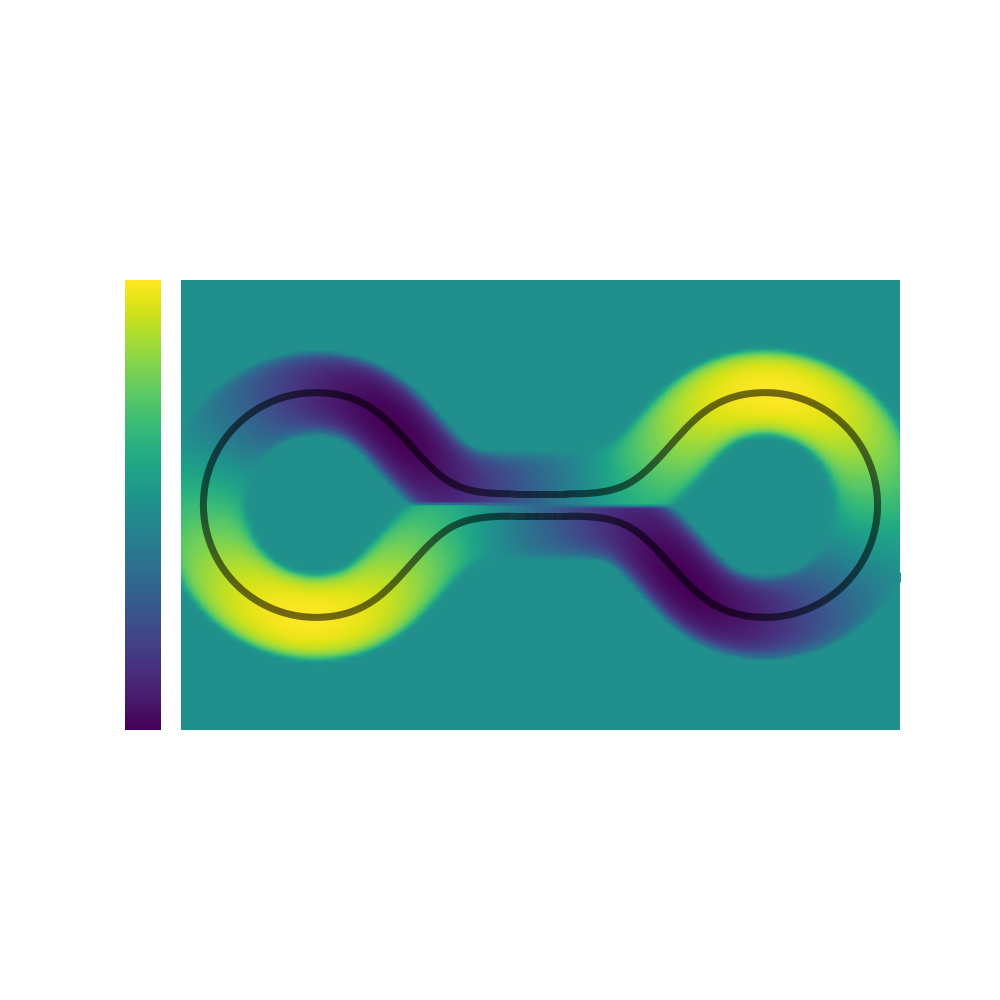

In [25]:
with torch.no_grad():
    c = kernel.base_kernel.ball_scale
    laplace_features_ambient = (scale_ambient*kernel.base_kernel.features(grid_x,  normalize=True, c=c)[:,3]).cpu().numpy()
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    im = ax.contourf(x.cpu(), y.cpu(), laplace_features_ambient.reshape(resolution, -1), 500)
#     ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c='k', s=0.5)
#     ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
#     circle = plt.Circle((noisy_x.cpu().numpy()[0, 0], noisy_x.cpu().numpy()[0, 1]), 
#                         c*kernel.base_kernel.epsilon.cpu().numpy(), color='k', fill=False)
#     ax.add_patch(circle)
    for edge in edges:
        start = vertices[edge[0]]
        end = vertices[edge[1]]
        ax.plot([start[0], end[0]], [start[1], end[1]], color='black', zorder=1, linewidth='5',alpha=0.1)
        
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("left", size="5%", pad=0.2)
    cbar = fig.colorbar(im, cax=cax, ticks=[-1.85, 0, 1.1])
    cax.yaxis.set_ticks_position("left")
    cbar.outline.set_visible(False)
    cbar.set_ticks([])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    fig.patch.set_visible(False)
    ax.axis('off')
    
    for c in im.collections:
        c.set_edgecolor("face")
    
    ax.axis('equal')
    fig.savefig("1d_feature_3.png", format="png", bbox_inches="tight")

### Ambient Prior Standard Deviation

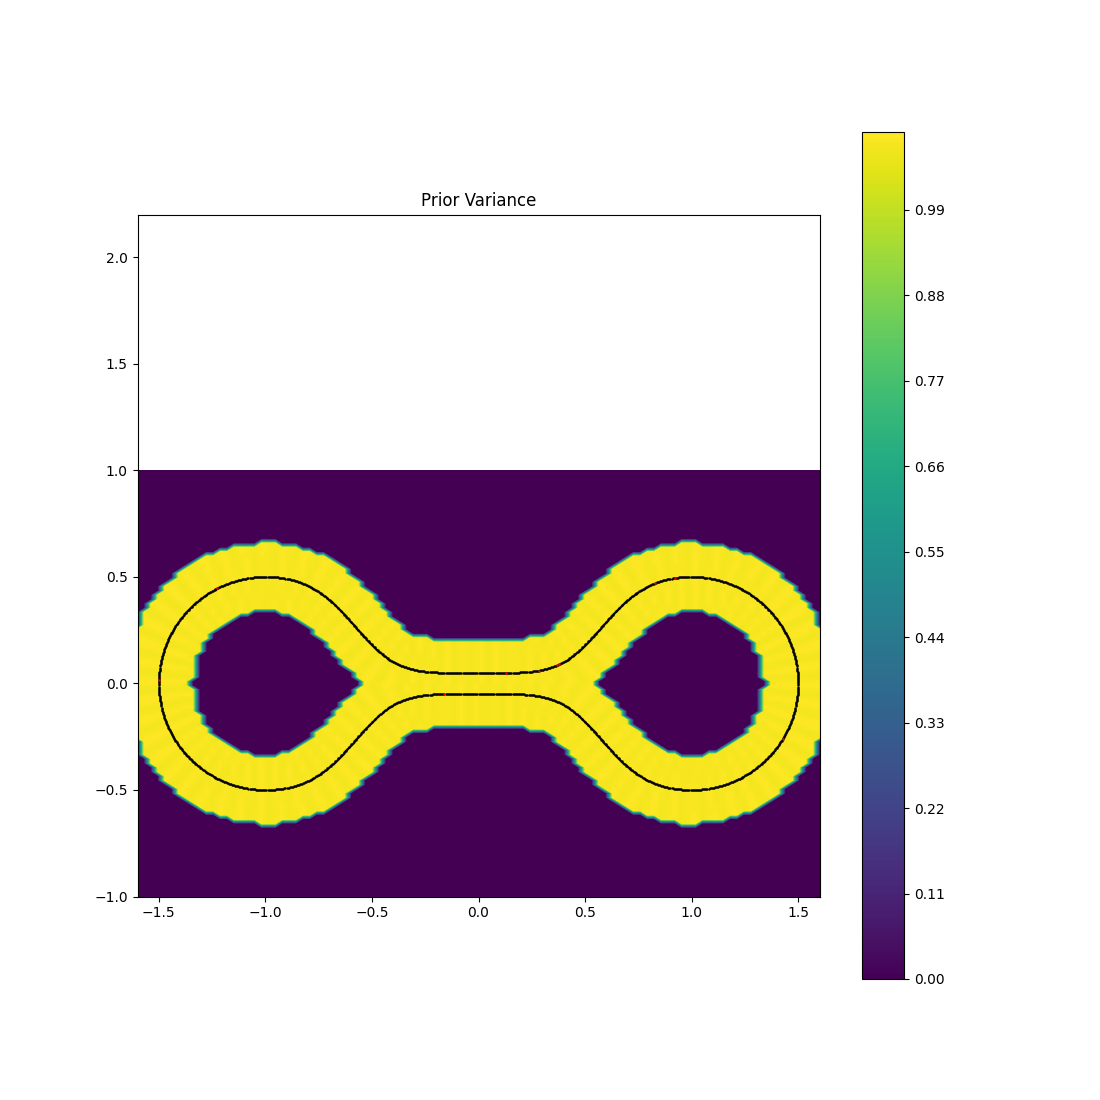

In [23]:
with torch.no_grad():
    prior_std_ambient = model.covar_module(grid_x, grid_x, diag=True).cpu().numpy()
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), prior_std_ambient.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), prior_var_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c='k', s=0.5)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Prior Variance')

### Ambient Posterior Standard Deviation

/home/bernardo/.local/lib/python3.10/site-packages/gpytorch/distributions/multivariate_normal.py:276: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


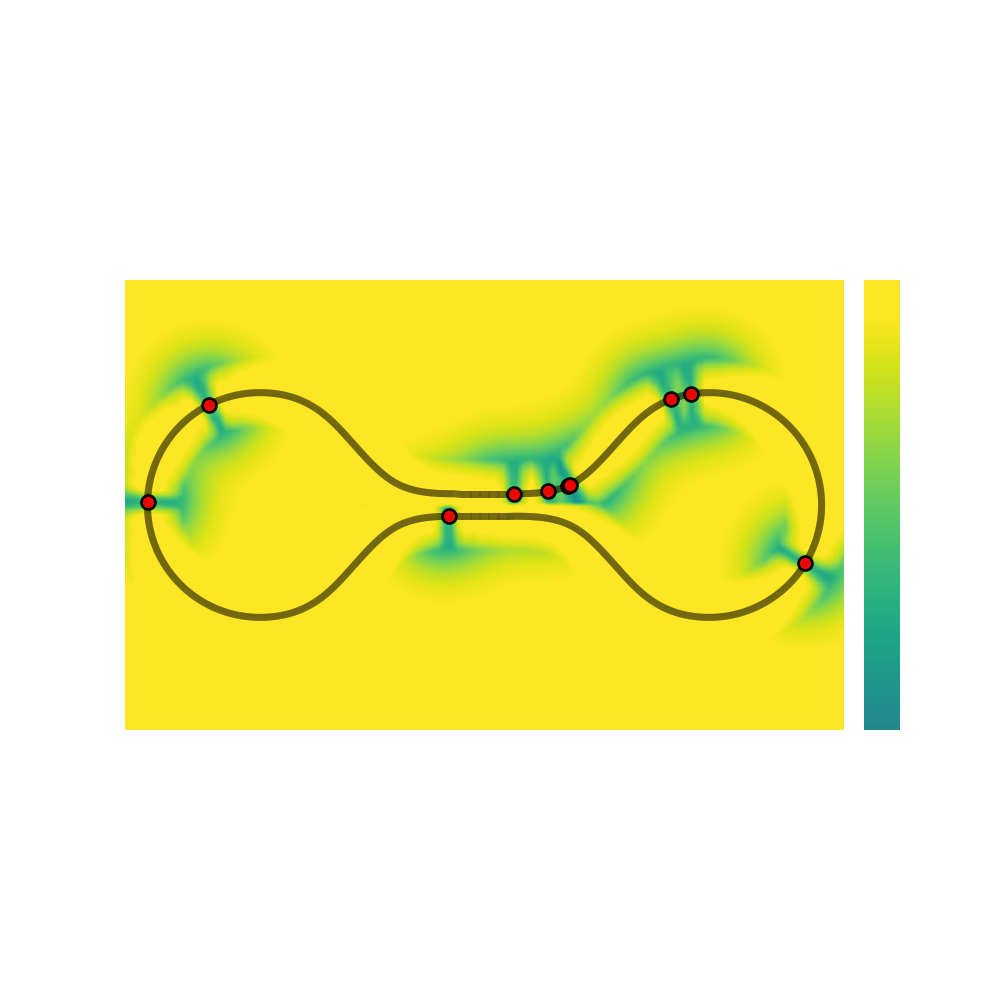

In [24]:
with torch.no_grad():
#     posterior_std_ambient = preds_ambient.stddev.cpu().numpy()
#     posterior_std_ambient = preds_vanilla.stddev.cpu().numpy()
    posterior_std_ambient = (scale_ambient*preds_ambient.stddev + (1-scale_ambient)*preds_vanilla.stddev).cpu().numpy()
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    im = ax.contourf(x.cpu(), y.cpu(), posterior_std_ambient.reshape(resolution, -1), 500, vmin=0, vmax=1)
    # ax.contour(x.cpu(), y.cpu(), posterior_std_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
#     ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c='k', s=0.5)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], facecolors='red',s=100.0, zorder=2, 
               edgecolors='black', linewidth=2, alpha=0.9)
    for edge in edges:
        start = vertices[edge[0]]
        end = vertices[edge[1]]
        ax.plot([start[0], end[0]], [start[1], end[1]], color='black', zorder=1, linewidth='5',alpha=0.1)
        
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = fig.colorbar(im, cax=cax, ticks=[-1.85, 0, 1.1])
    cax.yaxis.set_ticks_position("left")
    cbar.outline.set_visible(False)
    cbar.set_ticks([])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    fig.patch.set_visible(False)
    ax.axis('off')
    
    for c in im.collections:
        c.set_edgecolor("face")
    
    ax.axis('equal')
    fig.savefig("1d_riemann_uncertainty.png", format="png", bbox_inches="tight")
#     ax.set_title('Standard Deviation')

### Ambient Alpha Function

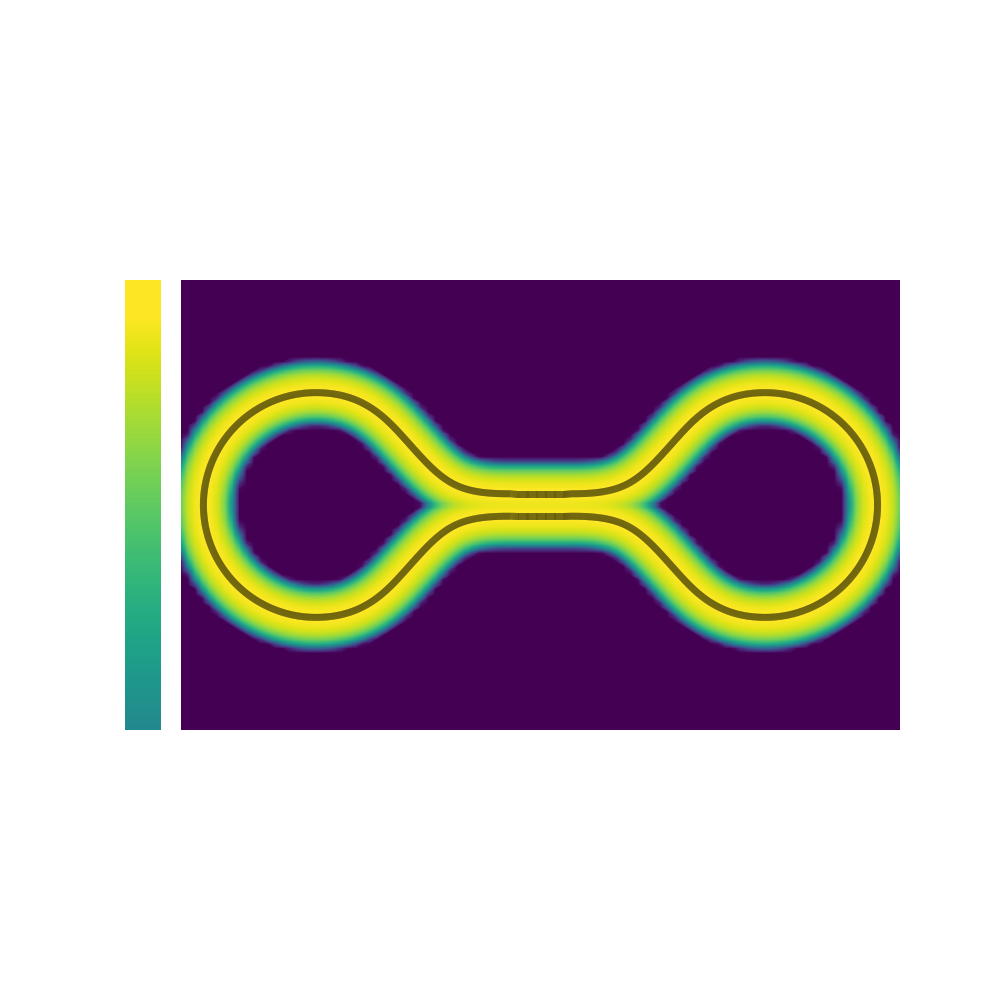

In [25]:
with torch.no_grad():
    c = kernel.base_kernel.ball_scale
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), scale_ambient.cpu().numpy().reshape(resolution, -1), 500)
#     ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c='k', s=0.5)
#     ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
#     circle = plt.Circle((noisy_x.cpu().numpy()[0, 0], noisy_x.cpu().numpy()[0, 1]), 
#                         c*kernel.base_kernel.epsilon.cpu().numpy(), color='k', fill=False)
#     ax.add_patch(circle)
    for edge in edges:
        start = vertices[edge[0]]
        end = vertices[edge[1]]
        ax.plot([start[0], end[0]], [start[1], end[1]], color='black', zorder=1, linewidth='5',alpha=0.1)
        
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("left", size="5%", pad=0.2)
    cbar = fig.colorbar(im, cax=cax, ticks=[-1.85, 0, 1.1])
    cax.yaxis.set_ticks_position("left")
    cbar.outline.set_visible(False)
    cbar.set_ticks([])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('equal')
    
    for c in im.collections:
        c.set_edgecolor("face")
    
    ax.axis('equal')
    fig.savefig("1d_alpha_fun.png", format="png", bbox_inches="tight")